The goal of this notebook is to replicate the work of DBauer1999 (Bauer, D., & Mulser, P. (1999). Exact field ionization rates in the barrier-suppression regime from numerical time-dependent Schrödinger-equation calculations. Physical Review A, 59(1), 569–577. https://doi.org/10.1103/PhysRevA.59.569) and investigate correspondence between their results and our IDE model.

In [1]:
import logging
import os
import functools
import datetime

import numpy as np
import scipy.optimize as optim

import simulacra as si
import simulacra.units as u

import ionization as ion

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'Bauer1999')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    fig_dpi_scale = 1.5,
)

%matplotlib inline

One of the key figures in the paper is the fifth, which shows a comparison of different tunneling rates. I reproduce that figure here.

Note that we need to double the "tunneling rates" as calculated by my rate models to get the same plot as Bauer. This is because Bauer gives the tunneling rates in terms of the probability to remain bound, while mine effect the wavefunction directly (they're implemented this way so that they can be shared with the IDE model simulations, which need to act on the wavefunction itself, not it's square).

d:\githubprojects\ionization\src\ionization\tunneling\models.py:91: UserWarning: PosthumusRate uses a lower cutoff in the electric field amplitude that I haven't fully figured out yet
  warnings.warn(f"{self.__class__.__name__} uses a lower cutoff in the electric field amplitude that I haven't fully figured out yet")


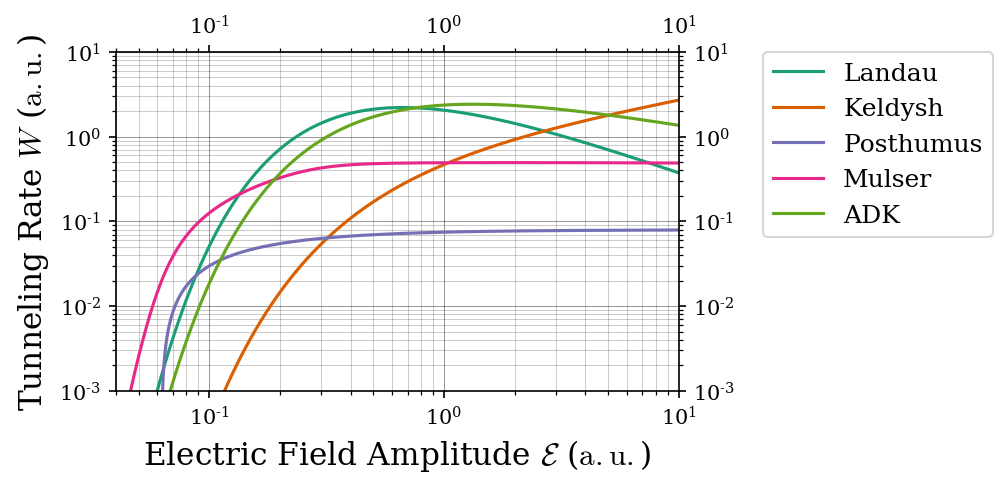

In [6]:
def make_dbauer1999_fig_5():
    tunneling_models = [
        ion.tunneling.LandauRate(),
        ion.tunneling.KeldyshRate(),
        ion.tunneling.PosthumusRate(),
        ion.tunneling.MulserRate(),
        ion.tunneling.ADKRate(),
        # ion.tunneling.ADKExtendedToBSIRate(),  # this one isn't working yet
    ]

    amplitudes = np.geomspace(.04, 10, 1000) * u.atomic_electric_field

    tunneling_rates = [
        np.abs(model.tunneling_rate_from_amplitude(amplitudes, -u.rydberg).squeeze())
        for model in tunneling_models
    ]
    labels = [model.__class__.__name__.rstrip('Rate') for model in tunneling_models]
    
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']

    si.vis.xy_plot(
        'tunneling_rates',
        amplitudes,
        *[2 * tr for tr in tunneling_rates],
        line_labels = labels,
        line_kwargs = [{'color': c} for c in colors[:len(tunneling_models)]],
        x_label = r'Electric Field Amplitude $ \mathcal{E} $',
        y_label = r'Tunneling Rate $ W $',
        x_unit = 'atomic_electric_field',
        y_unit = 'per_atomic_time',
        x_log_axis = True,
        y_log_axis = True,
        y_lower_limit = .001 / u.atomic_time,
        y_upper_limit = 10 / u.atomic_time,
        y_log_pad = 1,
        legend_on_right = True,
        **PLOT_KWARGS
    )
    
make_dbauer1999_fig_5()

This is the laser pulse used by Bauer1999. It is not centered at $t=0$, but instead at half the number of cycles times the cycle time (i.e., the number of periods and the period). Note that $\varphi = 0$ is a sine-like pulse because of this time shift. 

In [3]:
class BauerGaussianPulse(ion.potentials.UniformLinearlyPolarizedElectricPotential):
    """Gaussian pulse as defined in DBauer1999. Phase = 0 is a sine-like pulse."""

    def __init__(
            self,
            amplitude = 0.3 * u.atomic_electric_field,
            omega = .2 * u.atomic_angular_frequency,
            number_of_cycles = 6,
            phase = 0,
            **kwargs):
        super().__init__(**kwargs)

        self.amplitude = amplitude
        self.omega = omega
        self.number_of_cycles = number_of_cycles
        self.phase = phase

        self.pulse_center = number_of_cycles * u.pi / self.omega
        self.sigma2 = (self.pulse_center ** 2 / (4 * np.log(20)))

    @property
    def cycle_time(self):
        return 2 * self.pulse_center / self.number_of_cycles

    def get_electric_field_envelope(self, t):
        return np.exp(-((t - self.pulse_center) ** 2) / (4 * self.sigma2))

    def get_electric_field_amplitude(self, t):
        amp = self.get_electric_field_envelope(t) * np.sin((self.omega * t) + self.phase)

        return amp * self.amplitude * super().get_electric_field_amplitude(t)
    
    @property
    def identifier(self):
        return f'E={u.uround(self.amplitude, u.atomic_electric_field, 2)}_Nc={self.number_of_cycles}_omega={u.uround(self.omega, u.atomic_angular_frequency, 2)}'

Bauer1999 recommends a tunneling model given by $W = -2.4 \, \mathcal{E}^2$ when the electric field is larger than the critical field, and by the Landau tunneling rate below that. Here's that as a `TunnelingModel`. Remember that that prefactor, $-2.4$, corresponds to $-1.2$ the way I do things.

In [4]:
class BauerLandauRate(ion.tunneling.LandauRate):
    def __init__(self, prefactor = -1.2):
        super().__init__()
        
        self.prefactor = prefactor
        
    def tunneling_rate_from_amplitude(self, electric_field_amplitude, ionization_potential):
        landau_rate = super().tunneling_rate_from_amplitude(electric_field_amplitude, ionization_potential)
        bauer_rate = self.empirical_rate(electric_field_amplitude)
        
        critical_field = self.critical_electric_field_amplitude(ionization_potential)
        
        rate = np.where(
            np.abs(electric_field_amplitude) <= critical_field,
            landau_rate,
            bauer_rate,
        ).squeeze()

        return rate
    
    def empirical_rate(self, electric_field_amplitude):
        scaled_amplitude = np.abs(electric_field_amplitude) / u.atomic_electric_field
        empirical_rate = self.prefactor * (scaled_amplitude ** 2) / u.atomic_time
        
        return empirical_rate
    
    def critical_electric_field_amplitude(self, ionization_potential):
        """Determine the electric field amplitude where the empirical and tunneling rates are equal, which is where we should switch over."""
        sup = super()
        critical_field = optim.brentq(
            lambda amp: sup.tunneling_rate_from_amplitude(amp, ionization_potential) - self.empirical_rate(amp),
            .01 * u.atomic_electric_field,
            .5 * u.atomic_electric_field,
        )

        return critical_field

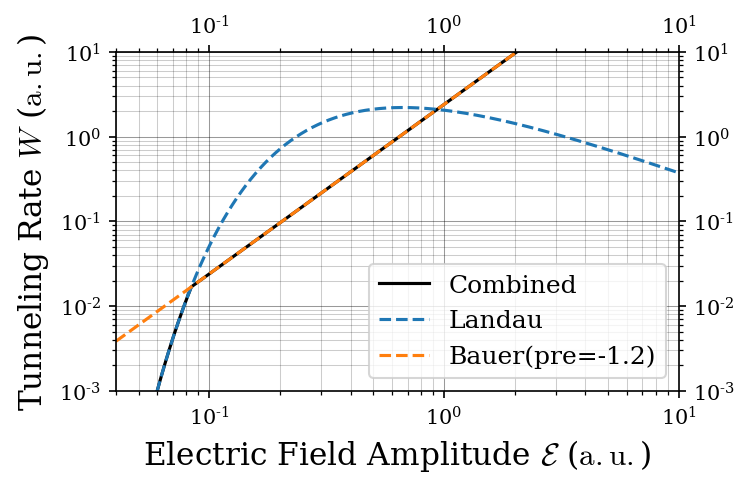

In [5]:
def plot_combined_bauer_landau_tunneling_rate():
    amplitudes = np.geomspace(.04, 10, 1000) * u.atomic_electric_field
    landau_model = ion.tunneling.LandauRate()
    bauer_model = BauerLandauRate()
    si.vis.xy_plot(
        'bauer_landau_tunneling_rate',
        amplitudes,
        2 * np.abs(bauer_model.tunneling_rate_from_amplitude(amplitudes, -u.rydberg)),
        2 * np.abs(landau_model.tunneling_rate_from_amplitude(amplitudes, -u.rydberg)),
        2 * np.abs(bauer_model.empirical_rate(amplitudes)),
        line_labels = [
            r'Combined',
            r'Landau',
            rf'Bauer(pre={bauer_model.prefactor})',
        ],
        line_kwargs = [
            {'color': 'black'},
            {'linestyle': '--'},
            {'linestyle': '--'},
        ],
        x_label = r'Electric Field Amplitude $ \mathcal{E} $',
        y_label = r'Tunneling Rate $ W $',
        x_unit = 'atomic_electric_field',
        y_unit = 'per_atomic_time',
        x_log_axis = True,
        y_log_axis = True,
        y_lower_limit = .001 * u.per_atomic_time,
        y_upper_limit = 10 * u.per_atomic_time,
        y_log_pad = 1,
        **PLOT_KWARGS
    )
    
plot_combined_bauer_landau_tunneling_rate()

Let's run simulations for the TDSE (radial/spherical-harmonic mesh), the tunneling model, and the IDE model (w/ plain Landau tunneling rate).

In [6]:
amplitudes = np.array([.3, .5]) * u.atomic_electric_field
number_of_cycles = [6, 12]
pulses = [
    BauerGaussianPulse(
        amplitude = amp,
        number_of_cycles = nc,
        omega = .2 * u.atomic_angular_frequency,
        phase = 0,
    )
    for amp in amplitudes
    for nc in number_of_cycles
]

tdse_specs = [
    ion.mesh.SphericalHarmonicSpecification(
        'TDSE_' + pulse.identifier,
        r_bound = 100 * u.bohr_radius,
        r_points = 500,
        l_bound = 300,
        time_initial = -pulse.pulse_center,
        time_final = 3 * pulse.pulse_center,
        time_step = 1 * u.asec,
        electric_potential = pulse,
        mask = ion.potentials.RadialCosineMask(inner_radius = 80 * u.bohr_radius, outer_radius = 100 * u.bohr_radius),
        use_numeric_eigenstates = True,
        numeric_eigenstate_max_energy = 20 * u.eV,
        numeric_eigenstate_max_angular_momentum = 5,
        checkpoints = True,
        checkpoint_dir = SIM_LIB,
        checkpoint_every = datetime.timedelta(minutes = 1),
    )
    for pulse in pulses
]

prefactor = -1.2  # aka the default; the value found by Bauer1999

tunneling_specs = [
    ion.tunneling.TunnelingSpecification(
        'TUNN_' + pulse.identifier + f'_prefactor={prefactor}',
        time_initial = -pulse.pulse_center,
        time_final = 3 * pulse.pulse_center,
        time_step = 1 * u.asec,
        electric_potential = pulse,
        tunneling_model = BauerLandauRate(prefactor = prefactor),
        ionization_potential = -u.rydberg,
    )
    for pulse in pulses
]

tdse_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in tdse_specs]
tunneling_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in tunneling_specs]

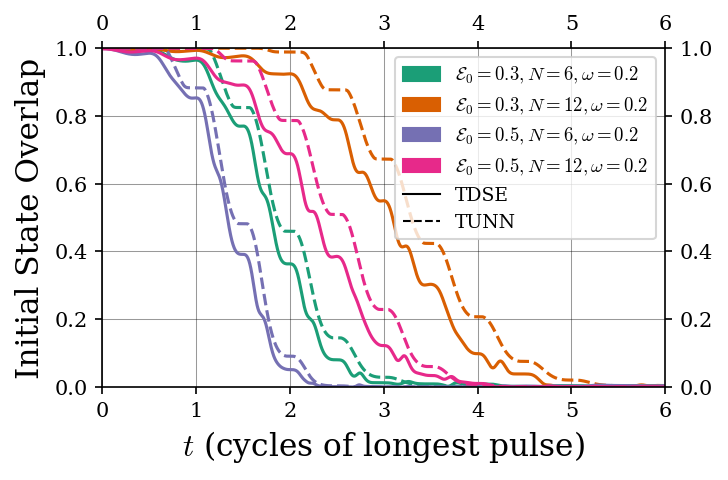

In [ ]:
def make_dbauer1999_fig_7(pulses, tdse_sims, tunneling_sims):
    longest_pulse = max(pulses, key = lambda p: p.pulse_center)

    x_data = []
    y_data = []
    line_labels = []
    line_kwargs = []
    
    colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a',]
    styles = ['-', '--',]
    
    color_labels = [sim.spec.electric_potential.identifier.replace('_', ',').replace('E', '\mathcal{E}_0').replace('Nc', 'N').replace('omega', '\omega')
                    for sim in tdse_sims]
    color_patches = [
        mpatches.Patch(
            color = color,
            label = f"$ {label} $",
        )
        for color, label in zip(colors, color_labels)
    ]

    style_labels = ['TDSE', 'TUNN']
    style_patches = [
        mlines.Line2D(
            [], [],
            color = 'black',
            linestyle = style, 
            linewidth = 1,
            label = sim_type,
        )
        for style, sim_type in zip(styles, style_labels)
    ]
    
    for tdse_sim, tunneling_sim, color in zip(tdse_sims, tunneling_sims, colors):
        x_data.append(tdse_sim.data.times)
        x_data.append(tunneling_sim.times)

        y_data.append(tdse_sim.data.initial_state_overlap)
        y_data.append(tunneling_sim.b2)

        for style in styles:
            line_kwargs.append({'linestyle': style, 'color': color})

    legend_handles = color_patches + style_patches

    si.vis.xxyy_plot(
        f'Bauer1999_fig5',
        x_data,
        y_data,
        line_labels = line_labels,
        line_kwargs = line_kwargs,
        x_label = r'$t$ (cycles of longest pulse)',
        x_unit = 2 * longest_pulse.pulse_center / longest_pulse.number_of_cycles,
        x_lower_limit = 0,
        x_upper_limit = longest_pulse.pulse_center,
        y_label = r'Initial State Overlap',
        y_lower_limit = 0,
        y_upper_limit = 1,
        y_pad = 0,
        font_size_legend = 9,
        legend_kwargs = dict(
            loc = 'upper right',
            ncol = 1,
            handles = legend_handles,
        ),
        fontsize_legend = 5,
        **PLOT_KWARGS
    )

make_dbauer1999_fig_7(pulses, tdse_results, tunneling_results)

In [ ]:
ide_specs = [
    ion.ide.IntegroDifferentialEquationSpecification(
        'IDE_' + pulse.identifier,
        time_initial = -pulse.pulse_center,
        time_final = 3 * pulse.pulse_center,
        time_step = 1 * u.asec,
        electric_potential = pulse,
        ionization_potential = -u.rydberg,
        checkpoints = True,
        checkpoint_dir = SIM_LIB,
        checkpoint_every = datetime.timedelta(minutes = 1),
    )
    for pulse in pulses
]

class LandauBelowCriticalField(BauerLandauRate):
    """A trick tunneling model for comparisons with the IDE model: the Landau model, but it cuts off at the critical field."""
    def tunneling_rate_from_amplitude(self, electric_field_amplitude, ionization_potential):
        landau_rate = super().tunneling_rate_from_amplitude(electric_field_amplitude, ionization_potential)
        
        critical_field = self.critical_electric_field_amplitude(ionization_potential)
        
        rate = np.where(
            np.less_equal(electric_field_amplitude, critical_field),
            landau_rate,
            0,
        ).squeeze()

        return rate

ide_with_tunneling_specs = [
    ion.ide.IntegroDifferentialEquationSpecification(
        'IDE_' + pulse.identifier + f'_prefactor={prefactor}',
        time_initial = -pulse.pulse_center,
        time_final = 3 * pulse.pulse_center,
        time_step = 1 * u.asec,
        electric_potential = pulse,
        tunneling_model = LandauBelowCriticalField(prefactor = prefactor),
        ionization_potential = -u.rydberg,
        checkpoints = True,
        checkpoint_dir = SIM_LIB,
        checkpoint_every = datetime.timedelta(minutes = 1),
    )
    for pulse in pulses
]

ide_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in ide_specs]
ide_with_tunneling_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in ide_with_tunneling_specs]

 43%|################5                     | 7924/18237 [02:27<06:21, 27.05it/s]